# Image analysis and morphological profiling in the bispecific antibody screen

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import javabridge
import bioformats as bf
import pandas as pd
import seaborn as sn
import random
import sys
import os
import re
import csv

from bioimg import load_image_series

javabridge.start_vm(class_path=bf.JARS)

In [2]:
path = '/Volumes/gitlab/microscopy/data/Tobias/newscreen/'
plate = 'Tag3'
for f in os.listdir(path):
    if re.search(plate + "_", f):
        screen_id = f
platedir = os.path.join(path, screen_id, 'Images')

In [3]:
fnames = [f for f in os.listdir(platedir) if '.tiff' in f]

In [4]:
all_wells = list(set([re.search('r[0-9]+c[0-9]+',f).group(0) for f in fnames]))
all_wells.sort()

In [5]:
well_id = 0
well = all_wells[well_id]
well_imgs = [f for f in fnames if well in f and 'ch2' not in f]

In [6]:
imglist = []
for i in range(1,5):
    wellpos = [f for f in well_imgs if 'f0' + str(i)+ 'p' in f]
    imgseries = load_image_series(path=platedir, imgfiles=wellpos)
    imgseries = imgseries.reshape((8, 4, 2160,2160))
    mipseries = np.amax(imgseries, axis=0)
    imglist.append(mipseries)

In [7]:
len(imglist)

4

In [8]:
imglist[0].shape

(4, 2160, 2160)

In [9]:
col_params = dict(colors=['blue', 'red', 
                          'yellow', 'green'],
                             blend = [2, 0.8, 0.8, 0.8],
                             gamma = [0.4, 0.3, 0.3, 0.3])

In [10]:
from bioimg import combine_channels
mip_color = combine_channels([imglist[3][i] for i in range(4)],
                             **col_params)

(-0.5, 999.5, 999.5, -0.5)

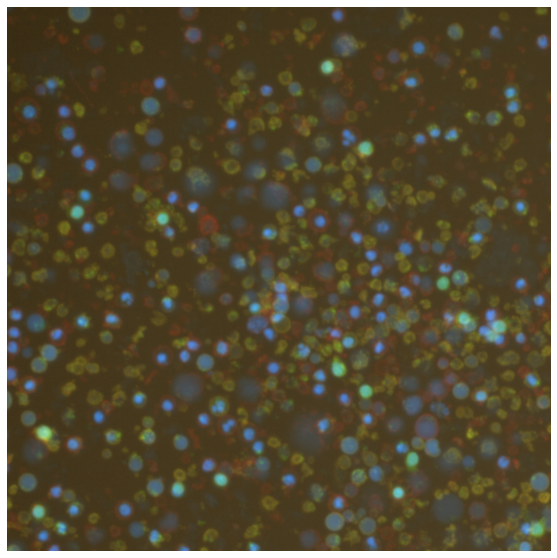

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(mip_color[:1000,:1000,:])
plt.axis('off')

## Segment B and T cell nuclei

In [12]:
hoechst = imglist[3][0]

In [13]:
from skimage.feature import shape_index, blob_log
from bioimg import threshold_img

def nantonum(img, pad=-1):
    img_r = np.copy(img)
    img_r[np.isnan(img_r)] = pad
    return img_r

In [14]:
gamma = 0.5
img_th = threshold_img(hoechst**gamma, method='otsu', binary=False)
img_s = shape_index(img_th)
img_enh = nantonum(img_s, pad=-1)

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/skimage/feature/corner.py:397: RuntimeWarning:

divide by zero encountered in true_divide

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/skimage/feature/corner.py:397: RuntimeWarning:

invalid value encountered in true_divide



In [15]:
# run LoG blob detection on the shape-index enhanced image
blobs_enh = blob_log(img_enh,
                 min_sigma=10, max_sigma=14, threshold=0.05)

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/skimage/feature/blob.py:125: RuntimeWarning:

invalid value encountered in double_scalars

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/skimage/feature/blob.py:126: RuntimeWarning:

divide by zero encountered in true_divide

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/skimage/feature/blob.py:127: RuntimeWarning:

divide by zero encountered in true_divide

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/skimage/feature/blob.py:129: RuntimeWarning:

invalid value encountered in subtract



In [16]:
'''fig, ax = plt.subplots(figsize=(10,10))
for blob in blobs_enh:
    y, x, r = blob
    c = plt.Circle((x, y), r+2, color='magenta', linewidth=1.4, fill=False)
    ax.add_patch(c)
ax.imshow(hoechst**0.5, cmap='gray')
ax.axis('off')'''

"fig, ax = plt.subplots(figsize=(10,10))\nfor blob in blobs_enh:\n    y, x, r = blob\n    c = plt.Circle((x, y), r+2, color='magenta', linewidth=1.4, fill=False)\n    ax.add_patch(c)\nax.imshow(hoechst**0.5, cmap='gray')\nax.axis('off')"

Convert "blobs" to bounding boxes:

In [17]:
pad = 5
bbox = np.stack([np.array([bl[1] - bl[2] - pad,
                           bl[1] + bl[2] + pad,
                           bl[0] - bl[2] - pad,
                           bl[0] + bl[2] + pad]) for bl in blobs_enh])

In [18]:
imax = hoechst.shape[0] - 1

In [19]:
bbox[bbox < 0] = 0
bbox[bbox > imax ] = imax

In [20]:
bbox = bbox.astype(int)

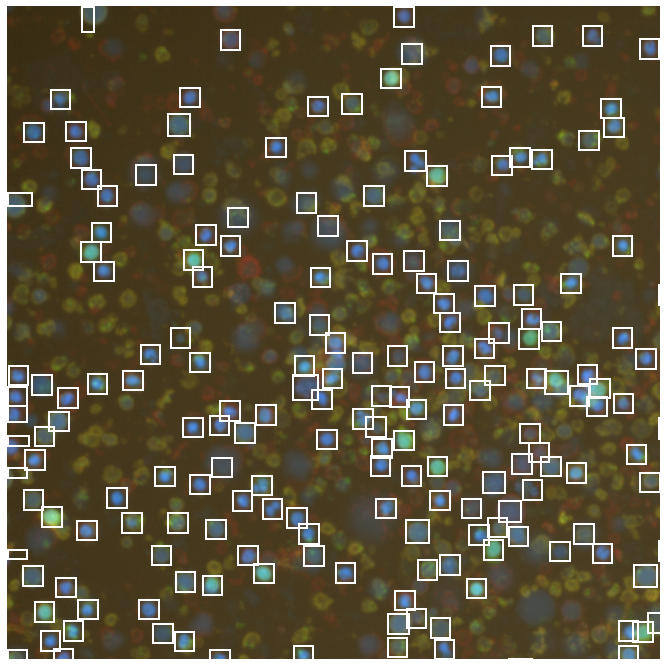

In [21]:
from bioimg import show_bbox
show_bbox(img=mip_color[:1000,:1000,:], bbox=bbox)

In [22]:
from bioimg import ImgX
# initialize 'ImgX' class
imgx = ImgX(img=imglist[3].swapaxes(0,-1), 
            bbox=bbox,
            n_chan=['Hoechst', 'PE',
                    'APC', 'Calcein'])

In [23]:
imgx.params['texture'] = 'both'
imgx.compute_props()
img_df = imgx.get_df().copy()

In [24]:
img_df.shape

(968, 1896)

In [25]:
img_df.head()

,ch-Hoechst-area,ch-Hoechst-mean_intensity,ch-Hoechst-centroid-0,ch-Hoechst-centroid-1,ch-Hoechst-convex_area,ch-Hoechst-eccentricity,ch-Hoechst-equivalent_diameter,ch-Hoechst-euler_number,ch-Hoechst-extent,ch-Hoechst-orientation,...,ch-Calcein-zernike-r20-39,ch-Calcein-zernike-r20-40,ch-Calcein-zernike-r20-41,ch-Calcein-zernike-r20-42,ch-Calcein-zernike-r20-43,ch-Calcein-zernike-r20-44,ch-Calcein-zernike-r20-45,ch-Calcein-zernike-r20-46,ch-Calcein-zernike-r20-47,ch-Calcein-zernike-r20-48
0,374,0.011077,14.719251,9.441176,389,0.355976,21.821815,1,0.774327,0.309509,...,9.195283e-18,3.370812e-18,3.890443e-18,0.054878,5.748274e-17,0.066722,5.323764e-17,0.054194,1.241096e-17,0.067657
0,83,0.003813,14.662651,26.481928,367,0.889510,10.280023,1,0.131746,-0.311152,...,1.828706e-02,5.338237e-03,9.636254e-03,0.050685,1.105467e-02,0.055510,1.441218e-02,0.068306,7.888709e-03,0.058412
0,198,0.003352,9.409091,9.020202,754,0.851006,15.877702,1,0.220000,0.688216,...,7.357222e-03,7.489425e-03,8.235816e-03,0.066525,1.229531e-02,0.095216,1.153039e-02,0.057114,7.285817e-03,0.055444
0,198,0.004181,5.964646,14.101010,207,0.501858,15.877702,1,0.831933,-1.449987,...,1.201239e-02,4.390986e-03,8.422497e-03,0.116898,4.822813e-02,0.023266,2.175343e-02,0.058129,1.479370e-03,0.042467
0,130,0.049799,3.715385,8.069231,134,0.779872,12.865502,1,0.722222,-1.435737,...,9.195283e-18,3.370812e-18,3.890443e-18,0.054878,5.748274e-17,0.066722,5.323764e-17,0.054194,1.241096e-17,0.067657


<AxesSubplot:xlabel='ch-Calcein-mean_intensity'>

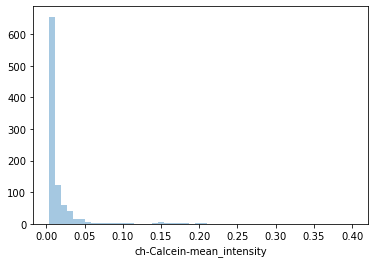

In [26]:
sn.distplot(img_df['ch-Calcein-mean_intensity'], kde=False)

## Spatial Cluster Quantification
Threshold Calcein channel and perform morphological dilation to find clusters:

(-0.5, 2159.5, 2159.5, -0.5)

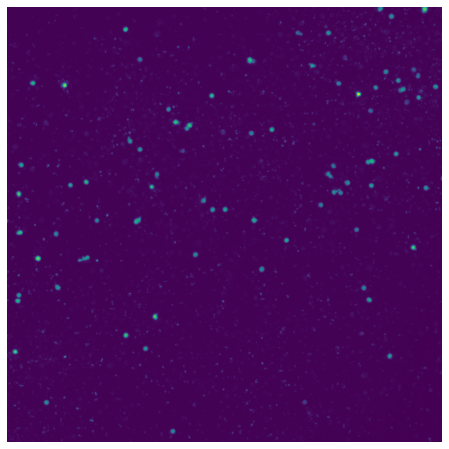

In [27]:
# get calcein channel
ca = imglist[3][3]

plt.figure(figsize=(8,8))
plt.imshow(ca**0.7)
plt.axis('off')

This well image doesn't have any clusters. However, apply morphological dilation and check the behavior:

(-0.5, 2159.5, 2159.5, -0.5)

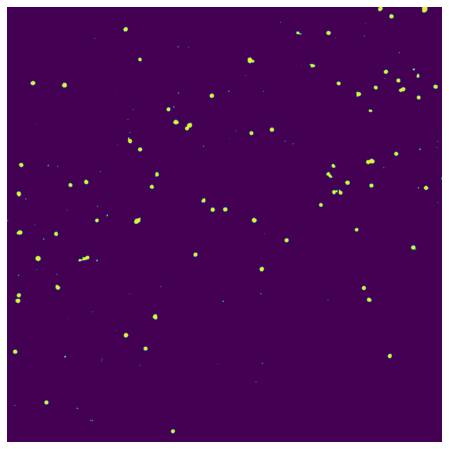

In [28]:
# threshold the Calcein channel
ca_th = threshold_img(ca, method='otsu', binary=True)

plt.figure(figsize=(8,8))
plt.imshow(ca_th)
plt.axis('off')

(-0.5, 2159.5, 2159.5, -0.5)

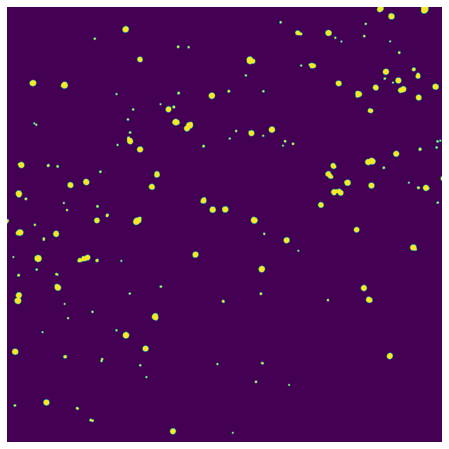

In [29]:
from skimage.morphology import binary_dilation, disk

ca_dil = binary_dilation(ca_th, disk(5))
plt.figure(figsize=(8,8))
plt.imshow(ca_dil)
plt.axis('off')

Next only select objects with Calcein area > 100, i.e. the identified "clusters" have to be at least larger than a typical viable cell

In [30]:
from skimage.measure import label
from skimage.color import label2rgb
from bioimg.segment.cv_methods import filter_segm

In [31]:
bounds = {'area': (1400, np.inf)}
segm = filter_segm(img=ca,
                    labels=label(ca_dil, connectivity=1),
                    bounds=bounds)

(-0.5, 2159.5, 2159.5, -0.5)

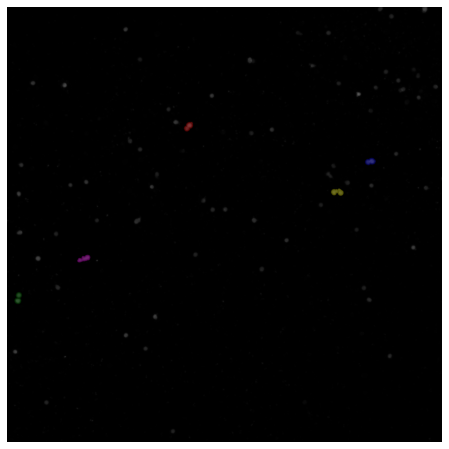

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(label2rgb(segm, image=ca, bg_label=0))
ax.axis('off')

Now load a different well -- the one that has some clusters:

In [33]:
well_id = 10
well = all_wells[well_id]
well_imgs = [f for f in fnames if well in f and 'ch2' not in f]

wellpos = [f for f in well_imgs if 'f02' + 'p' in f]
imgseries = load_image_series(path=platedir, imgfiles=wellpos)
imgseries = imgseries.reshape((8, 4, 2160,2160))
mip = np.amax(imgseries, axis=0)

(-0.5, 2159.5, 2159.5, -0.5)

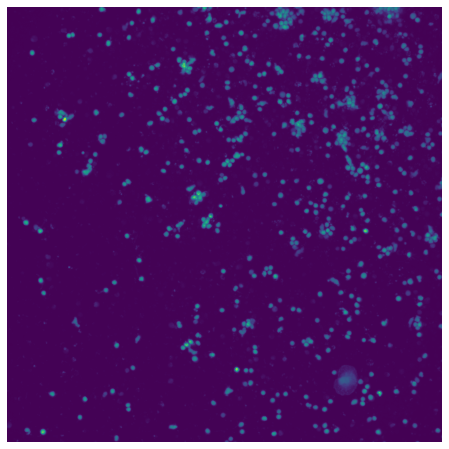

In [34]:
# get calcein channel
ca = mip[3]

plt.figure(figsize=(8,8))
plt.imshow(ca**0.7)
plt.axis('off')

(-0.5, 2159.5, 2159.5, -0.5)

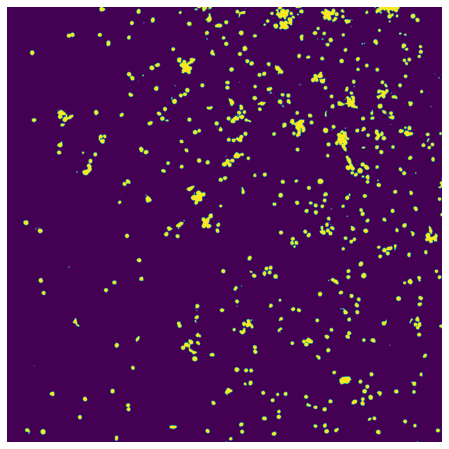

In [35]:
# threshold the Calcein channel
ca_th = threshold_img(ca, method='otsu', binary=True)

plt.figure(figsize=(8,8))
plt.imshow(ca_th)
plt.axis('off')

(-0.5, 2159.5, 2159.5, -0.5)

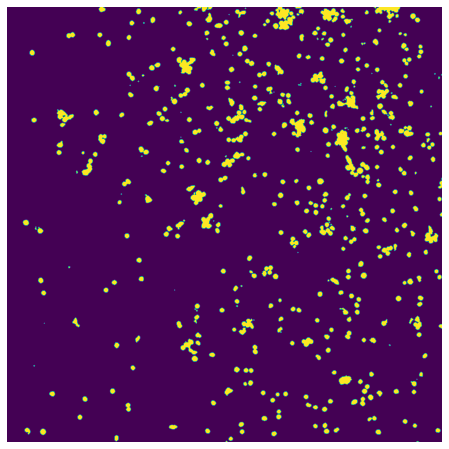

In [36]:
ca_dil = binary_dilation(ca_th, disk(2))
plt.figure(figsize=(8,8))
plt.imshow(ca_dil)
plt.axis('off')

In [37]:
bounds = {'area': (600, np.inf)}
segm = filter_segm(img=ca,
                    labels=label(ca_dil, connectivity=1),
                    bounds=bounds)

(-0.5, 2159.5, 2159.5, -0.5)

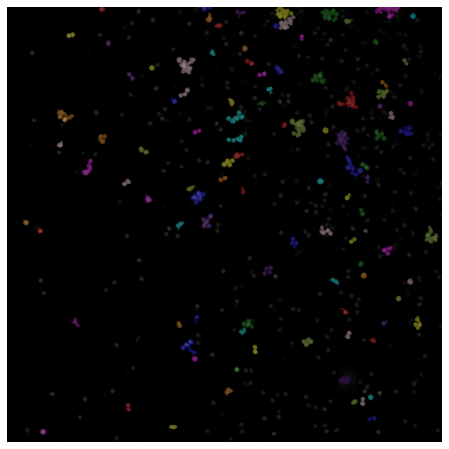

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(label2rgb(segm, image=ca, bg_label=0))
ax.axis('off')

In [39]:
from skimage.measure import regionprops_table
feats = regionprops_table(segm,
                       intensity_image=ca,
                      properties=['bbox'])

In [40]:
df = pd.DataFrame(feats)
df = df.rename(columns={'bbox-0': 'ymin',
                   'bbox-1': 'xmin',
                   'bbox-2': 'ymax',
                   'bbox-3': 'xmax'})

In [41]:
df.head()

,ymin,xmin,ymax,xmax
0,0,456,25,490
1,0,967,24,1020
2,0,1332,65,1422
3,0,1827,61,1953
4,6,1556,76,1649


In [42]:
rmax, cmax = ca.shape

In [43]:
from bioimg import read_bbox, show_bbox
bbox = read_bbox(df=df, rmax=rmax, cmax=cmax, pad=0)

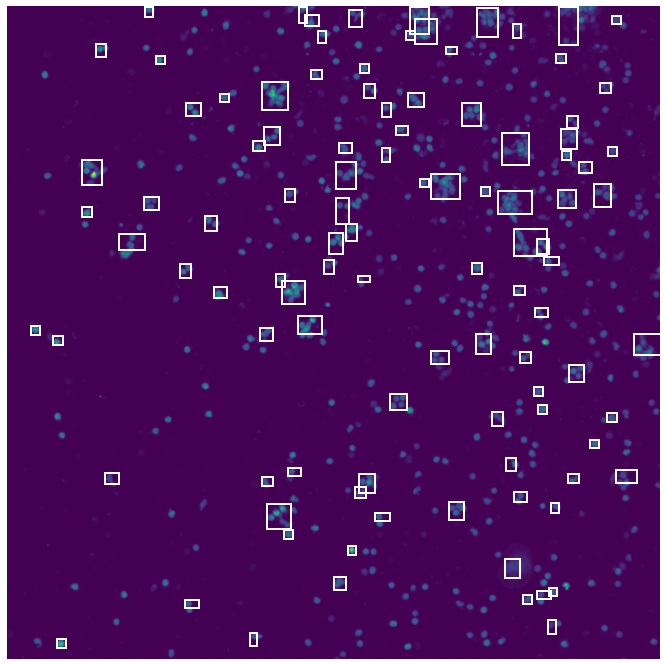

In [44]:
show_bbox(ca, bbox)

In [45]:
imgx = ImgX(img=mip.swapaxes(0,-1), 
            bbox=bbox,
            n_chan=['Hoechst', 'PE',
                    'APC', 'Calcein'])

In [46]:
imgx.compute_props()

In [47]:
img_df = imgx.get_df().copy()

In [48]:
img_df.shape

(104, 1272)